<a href="https://colab.research.google.com/github/rayan-arya/rayan-arya/blob/main/nfl_prediction_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
#drive.mount('/content/gdrive')

## Read data

In [ ]:
data_path='https://raw.githubusercontent.com/nflverse/nfldata/master/data/games.csv'
nfl_data = pd.read_csv(data_path)
nfl_data.head(2)

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17.0,ATL,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17.0,CHI,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field


## Make a copy of the dataset

In [ ]:
nfl_X = nfl_data.copy()

## Factorize columns

In [ ]:
teams = [city for i, city in enumerate(set(nfl_data['away_team']) & set(nfl_data['home_team'])) if city not in ['OAK', 'LV', 'SD', 'LAC', 'STL', 'LA']]
team_codes = {team: i for i, team in enumerate(teams)}
team_mod = {'LV': 29, 'OAK': 29, 'LAC': 30, 'SD': 30, 'STL': 31, 'LA': 31, 'LAR': 31}
team_codes.update(team_mod)
nfl_X['away_team'] = [team_codes[team] for team in nfl_data['away_team']]
nfl_X['home_team'] = [team_codes[team] for team in nfl_data['home_team']]

In [ ]:
nfl_X['weekday'] = nfl_data['weekday'].factorize()[0]
nfl_X['location'] = nfl_data['location'].factorize()[0]
nfl_X['surface'] = nfl_data['surface'].factorize()[0]
nfl_X['game_id'] = nfl_data['game_id'].factorize()[0]
nfl_X['season'] = nfl_data['season'].factorize()[0]
nfl_X['game_type'] = nfl_data['game_type'].factorize()[0]
nfl_X['gametime'] = nfl_data['gametime'].factorize()[0]
nfl_X['roof'] = nfl_data['roof'].factorize()[0]
nfl_X

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,0,0,0,1,1999-09-12,0,-1,14,17.0,0,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1,0,0,1,1999-09-12,0,-1,15,17.0,8,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,2,0,0,1,1999-09-12,0,-1,23,43.0,27,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,3,0,0,1,1999-09-12,0,-1,29,24.0,28,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,4,0,0,1,1999-09-12,0,-1,13,14.0,18,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,6688,24,0,18,2024-01-07,0,0,0,NaN,21,...,NaN,NaN,NaN,NaN,NaN,Arthur Smith,Dennis Allen,NaN,NOR00,Mercedes-Benz Superdome
6689,6689,24,0,18,2024-01-07,0,0,24,NaN,19,...,NaN,NaN,NaN,NaN,NaN,Nick Sirianni,Brian Daboll,NaN,NYC01,MetLife Stadium
6690,6690,24,0,18,2024-01-07,0,0,31,NaN,5,...,NaN,NaN,NaN,NaN,NaN,Sean McVay,Kyle Shanahan,NaN,SFO01,Levi's Stadium
6691,6691,24,0,18,2024-01-07,0,0,17,NaN,6,...,NaN,NaN,NaN,NaN,NaN,Doug Pederson,Mike Vrabel,NaN,NAS00,Nissan Stadium


## Determine Y labels (winning team) based on score

In [ ]:
score = nfl_X['home_score'] - nfl_X['away_score']
nfl_Y = pd.DataFrame(pd.Series([nfl_X.iloc[i]['home_team'] if score > 0 else nfl_X.iloc[i]['away_team'] for i, score in enumerate(score)]), columns=['win'])
nfl_Y

,win
0,14
1,8
2,23
3,28
4,18
...,...
6688,0
6689,24
6690,31
6691,17


## Visualize distribution of teams in dataset

In [ ]:
print(team_codes)

{'ATL': 0, 'BAL': 1, 'TB': 2, 'HOU': 3, 'DEN': 4, 'SF': 5, 'TEN': 6, 'CIN': 7, 'CHI': 8, 'NE': 9, 'SEA': 10, 'NYJ': 11, 'ARI': 12, 'BUF': 13, 'MIN': 14, 'KC': 15, 'WAS': 16, 'JAX': 17, 'IND': 18, 'NYG': 19, 'DAL': 20, 'NO': 21, 'MIA': 22, 'PIT': 23, 'PHI': 24, 'CAR': 25, 'DET': 26, 'CLE': 27, 'GB': 28, 'LV': 29, 'OAK': 29, 'LAC': 30, 'SD': 30, 'STL': 31, 'LA': 31, 'LAR': 31}


In [ ]:
nfl_Y['win'].value_counts()

9     308
23    265
28    262
18    256
1     251
24    248
10    243
15    235
21    233
4     220
14    220
6     219
20    219
30    209
31    207
19    204
0     203
5     202
25    200
2     199
13    197
22    196
8     192
7     189
11    183
12    180
16    177
29    169
17    167
3     154
26    150
27    136
Name: win, dtype: int64

Text(0.5, 1.0, 'Distribution of Winning Teams')

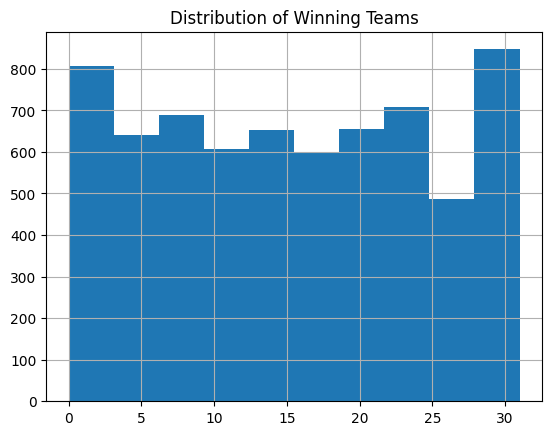

In [ ]:
nfl_Y['win'].hist()
plt.title('Distribution of Winning Teams')

## Select features

In [ ]:
nfl_X.columns

Index(['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday',
       'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game',
       'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id',
       'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium'],
      dtype='object')

In [ ]:
keep_columns = ['season', 'game_type', 'week', 'weekday',
       'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
       'location', 'result', 'total', 'overtime', 'espn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game',
       'roof', 'surface', 'temp', 'wind']

# Not using these:
#'game_id'
# old_game_id
# nfl_detail_id
# pfr
# gameday
# away_qb_name
# home_qb_name
# away_coach
# home_coach
# referee
# stadium_id
# stadium
# gsis
# pff

nfl_X_subset = nfl_X[keep_columns]
nfl_X_subset

,season,game_type,week,weekday,gametime,away_team,away_score,home_team,home_score,location,...,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind
0,0,0,1,0,-1,14,17.0,0,14.0,0,...,NaN,NaN,49.0,NaN,NaN,0,0,0,NaN,NaN
1,0,0,1,0,-1,15,17.0,8,20.0,0,...,NaN,NaN,38.0,NaN,NaN,0,1,1,80.0,12.0
2,0,0,1,0,-1,23,43.0,27,0.0,0,...,NaN,NaN,37.0,NaN,NaN,1,1,1,78.0,12.0
3,0,0,1,0,-1,29,24.0,28,28.0,0,...,NaN,NaN,43.0,NaN,NaN,0,1,1,67.0,10.0
4,0,0,1,0,-1,13,14.0,18,31.0,0,...,NaN,NaN,45.5,NaN,NaN,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,24,0,18,0,0,0,NaN,21,NaN,0,...,100.0,-120.0,NaN,NaN,NaN,1,0,5,NaN,NaN
6689,24,0,18,0,0,24,NaN,19,NaN,0,...,-110.0,-110.0,NaN,NaN,NaN,1,1,2,NaN,NaN
6690,24,0,18,0,0,31,NaN,5,NaN,0,...,-110.0,-110.0,NaN,NaN,NaN,1,1,1,NaN,NaN
6691,24,0,18,0,0,17,NaN,6,NaN,0,...,-110.0,-110.0,NaN,NaN,NaN,1,1,1,NaN,NaN


## How many null values do we have in our dataset?

In [ ]:
nfl_X_subset.isnull().sum()

season                 0
game_type              0
week                   0
weekday                0
gametime               0
away_team              0
away_score           272
home_team              0
home_score           272
location               0
result               272
total                272
overtime             272
espn                 272
away_rest              0
home_rest              0
away_moneyline      1981
home_moneyline      1981
spread_line            0
away_spread_odds    1981
home_spread_odds    1981
total_line           256
under_odds          2240
over_odds           2240
div_game               0
roof                   0
surface                0
temp                2017
wind                2017
dtype: int64

In [ ]:
nfl_X_subset[['away_moneyline', 'home_moneyline', 'away_spread_odds', 'home_spread_odds', 'under_odds', 'over_odds', 'temp', 'wind']].describe()

,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,under_odds,over_odds,temp,wind
count,4712.000000,4712.000000,4712.000000,4712.000000,4453.000000,4453.000000,4676.000000,4676.000000
mean,83.084253,-129.625637,-53.860144,-53.773981,-66.670784,-76.395913,57.987382,8.531437
std,283.125267,320.494065,93.208486,93.390594,82.139535,73.974961,17.032478,5.432333
min,-1500.000000,-5000.000000,-137.000000,-146.000000,-125.000000,-125.000000,-6.000000,0.000000
25%,-141.000000,-270.000000,-110.000000,-110.000000,-108.000000,-109.000000,46.000000,5.000000
50%,139.000000,-154.000000,-105.000000,-105.000000,-105.000000,-105.000000,59.000000,8.000000
75%,239.000000,129.000000,100.000000,100.000000,-102.000000,-102.000000,71.000000,12.000000
max,2173.000000,1100.000000,138.000000,126.000000,113.000000,113.000000,109.000000,71.000000


## Fill NaN values with 0

In [ ]:
# replace NaN with mean
nfl_X_subset['temp'].fillna(nfl_X_subset['temp'].mean(), inplace=True)
nfl_X_subset['wind'].fillna(nfl_X_subset['wind'].mean(), inplace=True)

# replace with
nfl_X_subset['away_moneyline'].fillna(-100, inplace=True)
nfl_X_subset['home_moneyline'].fillna(-100, inplace=True)
nfl_X_subset['away_spread_odds'].fillna(-100, inplace=True)
nfl_X_subset['home_spread_odds'].fillna(-100, inplace=True)
nfl_X_subset['under_odds'].fillna(-100, inplace=True)
nfl_X_subset['over_odds'].fillna(-100, inplace=True)

nfl_X_subset

<ipython-input-39-fb6c8cd5992c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfl_X_subset['temp'].fillna(nfl_X_subset['temp'].mean(), inplace=True)
<ipython-input-39-fb6c8cd5992c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfl_X_subset['wind'].fillna(nfl_X_subset['wind'].mean(), inplace=True)
<ipython-input-39-fb6c8cd5992c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfl_X_subset['away_moneyline'].fillna(-100, inplace=Tr

,season,game_type,week,weekday,gametime,away_team,away_score,home_team,home_score,location,...,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind
0,0,0,1,0,-1,14,17.0,0,14.0,0,...,-100.0,-100.0,49.0,-100.0,-100.0,0,0,0,57.987382,8.531437
1,0,0,1,0,-1,15,17.0,8,20.0,0,...,-100.0,-100.0,38.0,-100.0,-100.0,0,1,1,80.000000,12.000000
2,0,0,1,0,-1,23,43.0,27,0.0,0,...,-100.0,-100.0,37.0,-100.0,-100.0,1,1,1,78.000000,12.000000
3,0,0,1,0,-1,29,24.0,28,28.0,0,...,-100.0,-100.0,43.0,-100.0,-100.0,0,1,1,67.000000,10.000000
4,0,0,1,0,-1,13,14.0,18,31.0,0,...,-100.0,-100.0,45.5,-100.0,-100.0,1,0,0,57.987382,8.531437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,24,0,18,0,0,0,NaN,21,NaN,0,...,100.0,-120.0,NaN,-100.0,-100.0,1,0,5,57.987382,8.531437
6689,24,0,18,0,0,24,NaN,19,NaN,0,...,-110.0,-110.0,NaN,-100.0,-100.0,1,1,2,57.987382,8.531437
6690,24,0,18,0,0,31,NaN,5,NaN,0,...,-110.0,-110.0,NaN,-100.0,-100.0,1,1,1,57.987382,8.531437
6691,24,0,18,0,0,17,NaN,6,NaN,0,...,-110.0,-110.0,NaN,-100.0,-100.0,1,1,1,57.987382,8.531437


In [ ]:
nfl_X_subset.isnull().sum()

season                0
game_type             0
week                  0
weekday               0
gametime              0
away_team             0
away_score          272
home_team             0
home_score          272
location              0
result              272
total               272
overtime            272
espn                272
away_rest             0
home_rest             0
away_moneyline        0
home_moneyline        0
spread_line           0
away_spread_odds      0
home_spread_odds      0
total_line          256
under_odds            0
over_odds             0
div_game              0
roof                  0
surface               0
temp                  0
wind                  0
dtype: int64

## Not including score information and team names in the features

In [ ]:
nfl_X_subset2 = nfl_X_subset.drop(columns=['home_score', 'away_score', 'result'])

## Create a Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(nfl_X_subset2, nfl_Y, test_size=0.3)

## Fit a Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(X_train, Y_train)

ValueError: ignored

## Predict and report accuracy

In [ ]:
Y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

ValueError: ignored

## Changing Y to binary class improves accuracy
0 = home team

1 = away team

In [ ]:
score = nfl_X['home_score'] - nfl_X['away_score']
nfl_Y = pd.DataFrame(pd.Series([0 if score > 0 else 1 for i, score in enumerate(score)]), columns=['win'])
nfl_Y

,win
0,1
1,0
2,1
3,0
4,0
...,...
6416,1
6417,0
6418,0
6419,0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(nfl_X_subset2, nfl_Y, test_size=0.3)
model = LogisticRegression()
model.fit(X_train, Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
Y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.56


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(nfl_X_subset2, nfl_Y, test_size=0.3)
model = LogisticRegression()
model.fit(X_train, Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
Y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.55


## Fit the most basic model: Linear Model

In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
params = np.append(linear_model.intercept_,linear_model.coef_)
#predictions = linear_model.predict(X_test)
params

array([ 4.35572642e-01,  5.32272044e-03,  2.47274122e-02,  9.54105084e-04,
       -1.17692077e-03, -3.25290138e-04, -1.49628427e-04, -1.38668241e-04,
        2.52324231e-02, -1.44330524e-04,  5.81702322e-02, -4.41463982e-10,
        6.33600301e-03,  1.41577801e-03, -6.12084732e-05, -7.13547221e-05,
       -3.07589890e-02,  1.51565019e-04,  1.12567927e-04,  8.16368742e-04,
        4.12984694e-05,  1.98927395e-04,  2.96697585e-02,  3.31493702e-03,
       -7.64500630e-03,  1.17549986e-03,  9.56056440e-04])

Above we see the weight of each feature

In [ ]:
Y_pred = linear_model.predict(X_test)
print('Accuracy of Linear Model on test set: {:.2f}'.format(linear_model.score(X_test, Y_test)))

Accuracy of Linear Model on test set: 0.12


## Trying SVM Classification Model

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [ ]:
Y_pred = clf.predict(X_test)
print('Accuracy of SVM Classifer on test set: {:.2f}'.format(clf.score(X_test, Y_test)))

Accuracy of SVM Classifer on test set: 0.55


## Trying a more expressive model MLP Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X_train, Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.01, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [ ]:
Y_pred = mlp.predict(X_test)
print('Accuracy of MLP on test set: {:.2f}'.format(mlp.score(X_test, Y_test)))

Accuracy of MLP on test set: 0.45


### Neural networks are data hungry, to get higher accuracy, we need more data.

## Let's try XGBoost Classifier -- best performance!

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(nfl_X_subset2, nfl_Y, test_size=0.7)
dTree_clf = DecisionTreeClassifier()
dTree_clf.fit(X_train,Y_train)

ValueError: ignored

In [ ]:
Y_pred = dTree_clf.predict(X_test)
print('Accuracy of MLP on test set: {:.2f}'.format(dTree_clf.score(X_test, Y_test)))

Accuracy of MLP on test set: 0.57


### XGBoost is learning a decision tree of our data. For example:
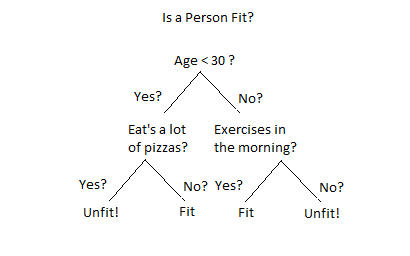

### Every node is a feature in the dataset. The model is trying to learn how to split the nodes and what boundaries to define, e.g. whether Age should be < 30, < 40, < 20.

[Stanford Youtube Video about Decision Tree Learning](https://www.youtube.com/watch?v=8Gc2AfeP5yE)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, Y_train, Y_test = train_test_split(nfl_X_subset2, nfl_Y, test_size=0.8)
gb_clf = GradientBoostingClassifier(n_estimators=30, learning_rate= .25, max_depth=5, random_state=1)
gb_clf.fit(X_train,Y_train)

ValueError: ignored

In [ ]:
Y_pred = gb_clf.predict(X_test)
print('Accuracy of MLP on test set: {:.2f}'.format(gb_clf.score(X_test, Y_test)))

Accuracy of MLP on test set: 0.62


In [ ]:
X_test

,season,game_type,week,weekday,gametime,away_team,home_team,location,total,overtime,...,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind
3998,15,0,2,0,0,25,18,0,39,0,...,-105.0,-105.0,43.0,-105.0,-105.0,1,1,7,58.000000,4.000000
1705,6,0,9,0,2,16,28,0,30,0,...,-100.0,-100.0,42.0,-100.0,-100.0,0,1,1,49.000000,16.000000
1727,6,0,11,0,0,15,19,0,41,0,...,-100.0,-100.0,45.0,-100.0,-100.0,0,1,1,51.000000,12.000000
1520,5,0,15,3,14,4,9,0,42,0,...,-100.0,-100.0,36.5,-100.0,-100.0,0,1,1,55.000000,0.000000
6262,23,0,9,0,0,25,10,0,67,0,...,-103.0,-107.0,46.0,-104.0,-108.0,0,1,1,58.000000,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3517,13,0,5,0,1,13,0,0,28,0,...,104.0,-113.0,42.5,-105.0,-105.0,0,1,1,63.000000,6.000000
6224,23,0,6,0,0,17,5,0,44,0,...,-107.0,-103.0,46.0,-110.0,-102.0,0,1,2,57.987382,8.531437
3014,11,0,7,0,2,19,30,0,43,0,...,-103.0,-105.0,49.0,103.0,-114.0,0,1,1,69.000000,7.000000
3521,13,0,5,0,28,18,9,0,48,0,...,-106.0,-102.0,45.5,-109.0,-101.0,0,1,1,62.000000,8.000000
